In [2]:
!python --version
!date

Python 3.11.12
Thu May 22 04:56:30 AM UTC 2025


# JGLUE（日本語言語理解ベンチマーク） + BoW
## JGLUEとは
2023年に構築された[日本語言語理解ベンチマーク](https://doi.org/10.5715/jnlp.30.63)の一つ。複数のタスクがある中から今回は JNLI (NLI = Natural Language Inference, 自然言語推論) を例に、事前学習済みBERTで分類学習するコード例を示す。

NLIとは、前提文と仮説文の文ペアが与えられたときに、前提文（premise sentence）が仮説文（hypothesis sentence）に対して持つ推論関係を「含意（entailment）」「矛盾（contradiction）」「中立（neutral）」の3値で識別するタスクである。


## 前提
[preprocessing.ipynb](./preprocessing.ipynb)を実行すると前処理された3つのpklファイル（preprocessed_{train,val,test}.pkl）が作成される。この3つのファイルをPCにダウンロードしておき、本コードを実行する環境で参照できるようにアップロードすること。

## データ準備
本データセットは [datsets.load_dataset()](https://huggingface.co/docs/datasets/loading) 経由でダウンロードできる。ダウンロードした後に以下の前処理を行い、学習データ、検証用データ、テストデータに整理し直している。実装に興味のある人は `report4_preprocessing.ipynb` と `utils.py` を参照しよう。
- get_dataで取得できるデータ説明
    - `sent1`: 前提文。
    - `sent2`: 仮説文。
    - `bow`: Bag-of-Words用に分かち書きした文。
    - `w2v`: word2vec用の分散ベクトル。
    - `label`: 教師ラベル。
        - "entailment" (含意): 0
        - "contradiction" (矛盾): 1
        - "neutral" (中立): 2
- ラベルの付け直し
    - 元データでは「含意（entailment）」「矛盾（contradiction）」「中立（neutral）」。これを 0, 1, 2 と付け直した。
- データセットの分割
    - 提供先で train（学習用）, validation（検証用）が用意されており、最終的な評価用のtestは非公開となっている。ここでは便宜上validationを評価用に用いることとする。

In [3]:
from utils import *

# 前処理済みデータ読み込み
df_train = get_data("preprocessed_train.pkl")
df_val = get_data("preprocessed_val.pkl")
df_test = get_data("preprocessed_test.pkl")

# 中身の確認
df_train.head()

,sent1,sent2,bow,w2v,label
0,二人の男性がジャンボジェット機を見ています。,2人の男性が、白い飛行機を眺めています。,二人 の 男性 が ジャンボジェット 機 を 見 て い ます 。 [SEP] 2人 の 男...,"[0.050462592, -0.13604076, 0.010860913, -0.197...",2
1,2人の男性が、白い飛行機を眺めています。,二人の男性がジャンボジェット機を見ています。,2人 の 男性 が 、 白い 飛行機 を 眺め て い ます 。 [SEP] 二人 の 男性...,"[0.088041924, -0.08648207, 0.014981923, -0.196...",2
2,男性が子供を抱き上げて立っています。,坊主頭の男性が子供を抱いて立っています。,男性 が 子供 を 抱き上げ て 立っ て い ます 。 [SEP] 坊主頭 の 男性 が ...,"[0.056786165, -0.1304283, 0.013041455, -0.1172...",2
3,坊主頭の男性が子供を抱いて立っています。,男性が子供を抱き上げて立っています。,坊主頭 の 男性 が 子供 を 抱い て 立っ て い ます 。 [SEP] 男性 が 子供...,"[0.042833548, -0.12648883, 0.002992845, -0.119...",0
4,草地の上で牛と男性が立っています。,農場で白い牛が男性の隣に立っています。,草地 の 上 で 牛 と 男性 が 立っ て い ます 。 [SEP] 農場 で 白い 牛 ...,"[0.13754506, -0.074033, 0.013317642, -0.165398...",2


In [4]:
# データセット毎のラベル分布チェック

import collections
print("train_labels: ", collections.Counter(df_train["label"]))
print("val_labels: ", collections.Counter(df_val["label"]))
print("test_labels: ", collections.Counter(df_test["label"]))

train_labels:  Counter({2: 11193, 1: 6004, 0: 2876})
val_labels:  Counter({2: 1350, 1: 735, 0: 349})
test_labels:  Counter({2: 1365, 1: 776, 0: 367})


## case 1: BoW (TF-IDF) + ロジスティック回帰
最も素朴な実装例として以下の通り実装した。なおpipelineを用いているためこれまでに示したコード例ともやや異なる点に注意。（これまでのコード例ベースで書き直してもOK）
- (1) 前提文と仮説文をそれぞれ分かち書きする。
- (2) 前提文と仮説文を「前提文[SEP]仮説文」として1つの文に結合する。ここまでの処理は report4_preprocessing.ipynb で実行済み。
- (3) 結合した文集合をTfidfVectorizerでベクトル化。
- (4) シンプルな分類モデル（LogisticRegression）で学習。

学習後、scikit-learnで用意されている [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) と、utils.py で用意した混同行列により大雑把な評価結果を出力している。それぞれの出力結果の読み方は[classification_report, ConfusionMatrixDisplayの実行例](classification_evaluations.ipynb)を参照。

=== BoW + LogisticRegression ===
               precision    recall  f1-score   support

   entailment       0.22      0.03      0.06       367
contradiction       0.54      0.29      0.37       776
      neutral       0.59      0.88      0.70      1365

     accuracy                           0.57      2508
    macro avg       0.45      0.40      0.38      2508
 weighted avg       0.52      0.57      0.51      2508



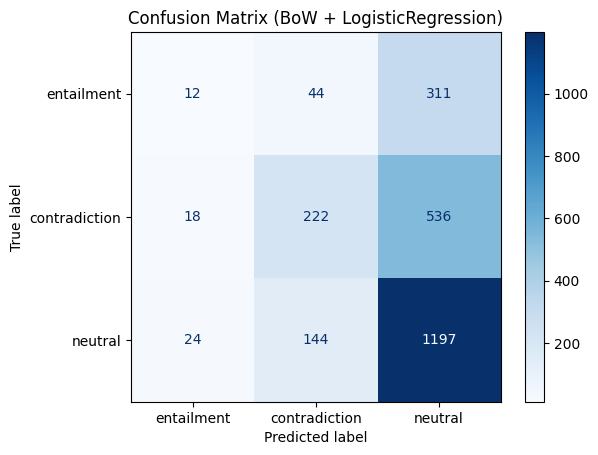

In [5]:
# ===============================
# ✅ 1. BoW(TF-IDF) + ロジスティック回帰
# ===============================
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_bow = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=200))
])

pipe_bow.fit(df_train["bow"], df_train["label"])
pred_bow = pipe_bow.predict(df_test["bow"])

print("=== BoW + LogisticRegression ===")
print(classification_report(df_test["label"],
                            pred_bow,
                            target_names=label2id.keys()))
plot_confusion("BoW + LogisticRegression",
               df_test["label"],
               pred_bow,
               labels=list(label2id.keys()))


In [6]:
# 検証データに対する失敗事例分析
pred_bow = pipe_bow.predict(df_val["bow"])
mis_df, mis_all_df = show_misclassified_examples(
    df_val["sent1"],
    df_val["sent2"],
    df_val["label"],
    pred_bow,
    id2label,
    samples_per_class=3, # ラベル辺りの出力件数
    random_seed=2025     # Noneにすると毎回ランダムになる
)

mis_df

,sent1,sent2,true_label,pred_label,true_label_name,pred_label_name
0,大型の警察用のバイクが置かれています。,大型のオートバイが１台駐輪しています。,0,2,entailment,neutral
1,文机の上にノートパソコンが置いてあります。,つくえのうえにパソコンがおかれています。,0,2,entailment,neutral
2,スーツ姿の男性がスキー板を履いて雪の上に立っています。,スーツ姿の男性がスキー板をつけて立っている。,0,2,entailment,neutral
3,草原の木立の中にキリンが一頭います。,草原の木立の中にキリンが二頭います。,1,0,contradiction,entailment
4,路線バスの前を男性が乗ったリカンベントが走っています。,路線バスの後ろを男性が乗ったリカンベントが走っています。,1,2,contradiction,neutral
5,スタジアムで野球の試合が行われています。,スタジアムで陸上競技が行われています。,1,2,contradiction,neutral
6,車道脇の歩道に荷車を引く馬がたっています。,乗用車の横に、荷台を引く白い馬が立っています。,2,1,neutral,contradiction
7,駅に機関車が停車しています。,蒸気機関車が駅のホームにとまっています。,2,0,neutral,entailment
8,ふきんの上にさかさまに伏せられたたくさんのグラスが置かれています。,流し台にたくさんのグラスが置かれています。,2,1,neutral,contradiction


In [19]:
# 検証データに対する全失敗事例をExcelファイルとして出力

true_label = df_val["label"].map(id2label)
pred_label = pd.Series(pred_bow).map(id2label)

mis_all_df = pd.DataFrame({
    "sent1":df_val["sent1"],
    "sent2":df_val["sent2"],
    "true_label":df_val["label"],
    "bow_pred_label":pred_bow,
    "true_label_name":true_label,
    "bow_pred_label_name":pred_label
})

mis_all_df.to_excel("mis_all_df_bow.xlsx")